In [89]:
from pylab import *
import scipy.integrate
import time
import math
import astropy.units as u
import astropy.time
import astropy.coordinates

# Computation of integral over line-of-sight for diffusive $\gamma$-ray emission

## 1. Galactic gas

### GALPROP

In [312]:
#Importing data
data = np.genfromtxt('/Users/luisenriqueespinosacastro/Documents/PhD/Research/Diffusive gamma rays/Diffusive_GammaRay_Emission/Galactic_Gas/gas_Galprop.txt')
radius = data[:,0]  #in kpc
height = data[:,1]  #in kpc
atomic_density = data[:,2] #in cm^-3
molecular_density = data[:,3] #in cm^-3
total_density = (atomic_density + molecular_density) * 1.42 #in cm^-3

In [313]:
Earth_position = 8.5  #in kpc

#Spherical to cartesian coordinates
def x(s, theta, phi):
    return ( s * math.sin(math.radians(theta)) * math.cos(math.radians(phi)) ) - Earth_position
def y(s, theta, phi):
    return s * math.sin(math.radians(theta)) * math.sin(math.radians(phi))
def z(s, theta):
    return s * math.cos(math.radians(theta))

#Cartesian to cylindircal coordinates
def r(s, theta, phi):
    xx = x(s, theta, phi)
    yy = y(s, theta, phi)
    return np.sqrt(xx**2 + yy**2)

In [289]:
def n(s, theta, phi):
    R = r(s, theta, phi)
    Z = z(s, theta)
    if R <= 19.9 and -2.0 <= Z <= 1.99:
        index_height = (np.abs(height - Z)).argmin()
        index_radius = np.where(np.logical_and(height==height[index_height], height==height[index_height]))
        gas = scipy.interpolate.CubicSpline(radius[index_radius], total_density[index_radius])
        density = gas(R)
    else:
        density = 0
    return density
n_GALPROP = np.vectorize(n)

#### Test plots

Text(0, 0.5, 'n')

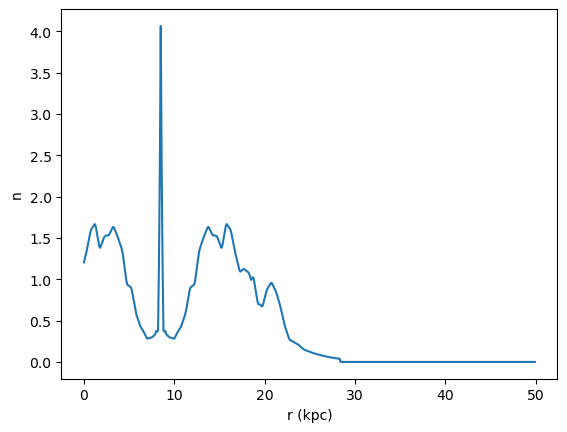

In [290]:
theta = 90
phi = 0
s = np.arange(0,50,0.1)
plt.plot(s, n_GALPROP(s, theta, phi))
plt.xlabel('r (kpc)')
plt.ylabel('n')

Text(0, 0.5, 'n')

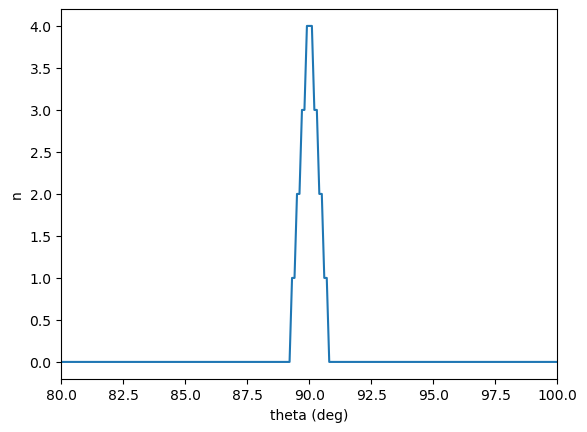

In [291]:
s = 8.5
theta=np.arange(0,180, 0.1)
phi = 0
plt.plot(theta, n_GALPROP(s, theta, phi))
plt.xlim(80,100)
plt.xlabel('theta (deg)')
plt.ylabel('n')

Text(0, 0.5, 'n')

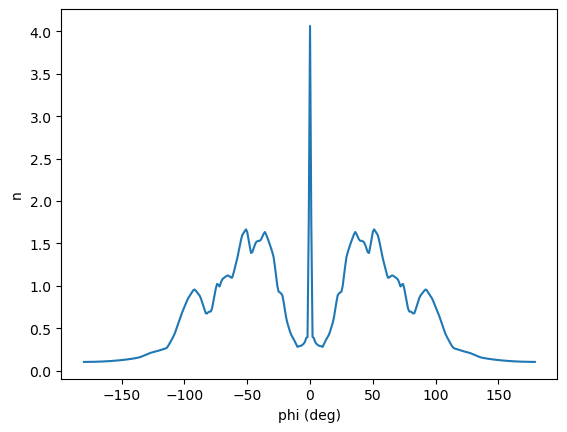

In [292]:
s = 8.5
phi=np.arange(-180,180)
theta = 90
plt.plot(phi, n_GALPROP(s, theta, phi))
plt.xlabel('phi (deg)')
plt.ylabel('n')

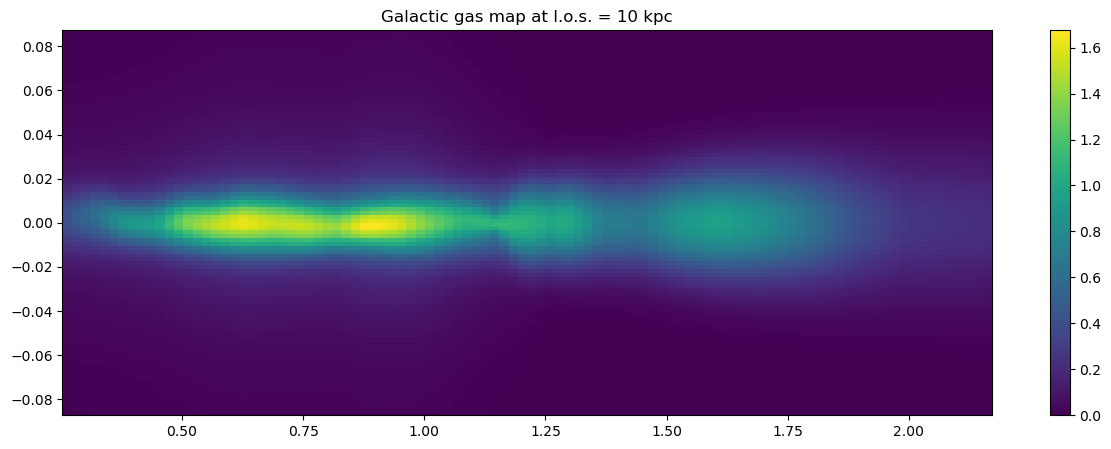

In [355]:
bmin = math.radians(-4.95)
bmax = math.radians(5.)
db = (bmax - math.radians(-5.)) / 100.
b = np.arange(bmin, bmax, db)

lmin = math.radians(15.05)
lmax = math.radians(125.)
dl = (lmax - lmin) / 100.
l = np.arange(lmin, lmax, dl)

density_map = np.zeros((len(l), len(b)))
for m in range(0, len(l)):
    for n in range(0, len(b)):
        density_map[m,n] = n_GALPROP(8.5, 90 - math.degrees(b[n]), math.degrees(l[m]))
        
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.pcolormesh(l, b, density_map.T)
fig.colorbar(im)
ax.set_title('Galactic gas map at l.o.s. = 10 kpc')
plt.show()

## 2. Optical depth

In [293]:
htagliatoC = 197.4 * 1e6 * 1e-13 #in eV cm
KB = 8.6 * 1e-5 #in eV K^-1
Relectron = 2.8179 * 10e-15 * 1e2 #in cm
htagliato = 6.58 * 1e-16 #in eV s
MassaE = 0.511 * 1e-6 #in TeV
MassaP = 938.27 * 1e-6 #in TeV
CaricaElettrone = 4.8 * 1e10 #in cm^(3/2) g^(1/2) s^-1
SigmaT = 6.65 * 1e-29 * 1e4 #in cm^2
kpctocm = 1e3 * 3.26 * 3.15 * 1e7 * 3.0 * 1e10

In [294]:
def xx1(Eg, ee, theta): 
    #ee in eV, Eg in GeV
    xx = 2 * Eg * ee * 1e-15 * ((1 - np.cos(theta)) / (4 * MassaE**2))
    return xx
vec_xx1 = np.vectorize(xx1)

In [295]:
def beta2(xx):
    if xx >= 1:
        beta = (1 - (1.0 / xx))**(0.5)
    if xx < 1:
        beta = 0
    return beta
vec_beta2 = np.vectorize(beta2)

In [296]:
def sigmaGG(beta):
    sigma = SigmaT * (3 / 16) * (1 - beta**2) * (2 * beta * (beta**2 - 2) + (3 - beta**4) * np.log((1 + beta) / (1 - beta)))
    return sigma
vec_sigmaGG = np.vectorize(sigmaGG)

In [297]:
def Ethr(ee, theta):
    E = 2 * MassaE / (ee * 1e-15 * (1 - np.cos(theta)))
    return E
vec_Ethr = np.vectorize(Ethr)

In [298]:
# Black body distribution
def n_bb(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1))
    return n #in eV^(-1) cm^(-3)
vec_n_bb = np.vectorize(n_bb)

def n_bb_ee(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1)) * ee
    return n #in cm^(-3)
vec_n_bb_ee = np.vectorize(n_bb_ee)

In [299]:
def EnergyDensityBB(T, nn):
    density = nn * scipy.integrate.quad(n_bb_ee, 0, 50 * KB * T, args=T) 
    return density #in eV cm^(-3)
vec_EnergyDensityBB = np.vectorize(EnergyDensityBB)

In [300]:
def integrand(ee, theta, T, Eg):
    integrand_value = np.sin(theta) * (1 - np.cos(theta)) * n_bb(ee, T) * sigmaGG(beta2(xx1(Eg, ee, theta)))
    return integrand_value
    
def KKProva(Eg, T):
    #integral = scipy.integrate.dblquad(integrand, 0, 500 * KB * T, 0, np.pi, args=(T, Eg))
    #integral = scipy.integrate.dblquad(integrand, 0, np.pi, 0, 500 * KB * T, args=(T, Eg))
    integral = scipy.integrate.dblquad(integrand, 0.0, np.pi, lambda x: 0.0, lambda x: 500 * KB * T, args=(T, Eg))
    KK = 2 * np.pi * kpctocm * integral[0]
    return KK #in kpc^(-1)
vec_KKProva = np.vectorize(KKProva)

In [301]:
logEg = np.arange(0, 9.09, 9/100)
Table = np.array((10**logEg, vec_KKProva(10**logEg, 2.7255)))
np.savetxt('absorption_table.txt', Table)
KK1 = scipy.interpolate.PchipInterpolator(Table[0,:], Table[1,:])

In [302]:
def tauABSiso(Eg, los):
    r = los  #in kpc
    tau = KK1(Eg) * r / (4 * np.pi)
    return tau
vec_tauABSiso = np.vectorize(tauABSiso)

#### Test plots

[]

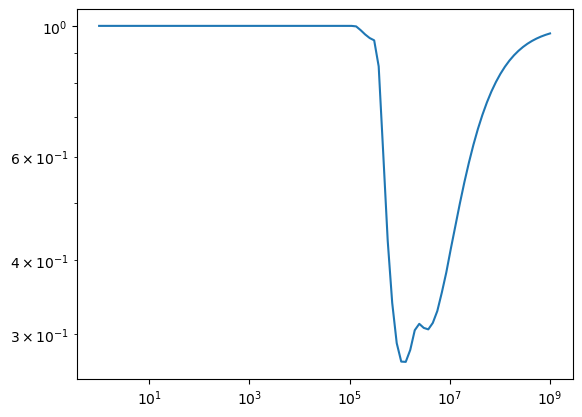

In [303]:
logEg = np.arange(0, 9.09, 9/100)
Eg = 10**logEg
plt.plot(Eg, e**-tauABSiso(Eg, 10))
plt.loglog()

## 3. Mask

In [304]:
def LHAASO_mask_old(l, b):
    
    # Inputs:
    # l in deg
    # b in deg
    
    data = np.genfromtxt('/Users/luisenriqueespinosacastro/Documents/PhD/Research/Diffusive gamma rays/Diffusive_GammaRay_Emission/Masks/LHAASO_old.txt')
    
    # Find l in mask data set
    data_l = np.abs(data[:,0] - l)
    index_l = np.where(data_l == data_l.min())
    
    # Find corresponding b's
    latitudes = data[:,1][index_l]
    values = data[:,2][index_l]
    
    # Find b in mask data set
    index_mask = np.where(np.logical_and(latitudes == b, latitudes == b))
    
    return values[max(index_mask[0])]
vec_mask = np.vectorize(LHAASO_mask_old)

In [305]:
def LHAASO_mask_new(l, b):
    data = np.genfromtxt('/Users/luisenriqueespinosacastro/Documents/PhD/Research/Diffusive gamma rays/Diffusive_GammaRay_Emission/Masks/LHAASO_new.txt')
    
    # RA, DEC and radius given in degrees, indicating regions (circles) of sky masked
    RA = data[:,0]
    DEC = data[:,1]
    r = data[:,2]
    
    value = 1
    for i in range(0, len(r)):
        if (b - math.radians(RA[i]))**2 + (l - math.radians(DEC[i]))**2 <= math.radians(r[i])**2:
            value *= 0
            
    return value

## Integral over line of sight

In [314]:
# FIRST INTEGRAL INTEGRAL

def solid_angle(b, l):
    return np.cos(b)
    
def Integral_los(Egamma, gas_model, sky_region):
    
    # Egamma - Gamma-ray energy [GeV]
    # theta - Latitude angle [degrees]
    # phi - Longitude angle [degrees]
    # gas_model - Options: GALPROP
    # sky_region - Options: innerGalaxy, outerGalaxy
    
    integral_gal_coord = 0
    
    # Sky regions of TIBET
    """
    if sky_region == 'innerGalaxy':
        bmin = math.radians(-5.)
        bmax = math.radians(5.)
        db = (bmax - bmin) / 50.
        b = np.arange(bmin, bmax, db)                         
        lmin = math.radians(25.)
        lmax = math.radians(100.)
        dl = (lmax - lmin) / 50.
        l = np.arange(lmin, lmax, dl)
        
    if sky_region== 'outerGalaxy':
        bmin = math.radians(-5.)
        bmax = math.radians(5.)
        db = (bmax - bmin) / 50.
        b = np.arange(bmin, bmax, db)                         
        lmin = math.radians(50.)
        lmax = math.radians(200.)
        dl = (lmax - lmin) / 50.
        l = np.arange(lmin, lmax, dl)
    """
    b_deg = np.arange(-4.95, 5., 0.1)
    b_deg = np.around(b_deg, 2)
    
    # Sky regions of LHAASO
    if sky_region == 'innerGalaxy':
        bmin = math.radians(-4.95)
        bmax = math.radians(5.)
        db = (bmax - math.radians(-5.)) / 100.
        b = np.arange(bmin, bmax, db)
        lmin = math.radians(15.)
        lmax = math.radians(125.)
        dl = (lmax - lmin) / 50.
        l = np.arange(lmin, lmax, dl)
    if sky_region== 'outerGalaxy':
        bmin = math.radians(-4.95)
        bmax = math.radians(5.)
        db = (bmax - math.radians(-5.)) / 100.
        b = np.arange(bmin, bmax, db)
        lmin = math.radians(125.)
        lmax = math.radians(235.)
        dl = (lmax - lmin) / 50.
        l = np.arange(lmin, lmax, dl)
        
    dOmega = scipy.integrate.dblquad(solid_angle, lmin, lmax, lambda x: bmin, lambda x: bmax)[0]
    
    integral_los = np.zeros((len(l), len(b)))
    for j in range(0, len(l)):
        #integral_los = np.zeros(len(b))
        for i in range(0, len(b)):
            theta = (np.pi/2) - b[i]
            phi = l[j]

            # Gas model
            los = np.arange(0, 30, 0.1) # in kpc
            if gas_model == 'GALPROP':
                n_gas = n_GALPROP(los, theta, phi) * a[j, i]

            # Optical depth
            tau = vec_tauABSiso(Egamma, los)

            integral_los[j,i] = scipy.integrate.simps(n_gas * np.exp(-tau), los) #* LHAASO_mask_old(math.degrees(l[j]), b_deg[i])
        #integral_gal_coord += scipy.integrate.simps(integral_los * np.cos(b), b) * dl
    return integral_los#integral_gal_coord / dOmega
vec_Integral_los = np.vectorize(Integral_los)

In [ ]:
integral = np.genfromtxt('MATRICES/integral_los_innerGalaxy_LHAASO_1e1.0.txt')
mask = np.genfromtxt('/Users/luisenriqueespinosacastro/Documents/PhD/Research/Diffusive gamma rays/Diffusive_GammaRay_Emission/Masks/LHAASO_oldmask_innerGalaxy.txt')

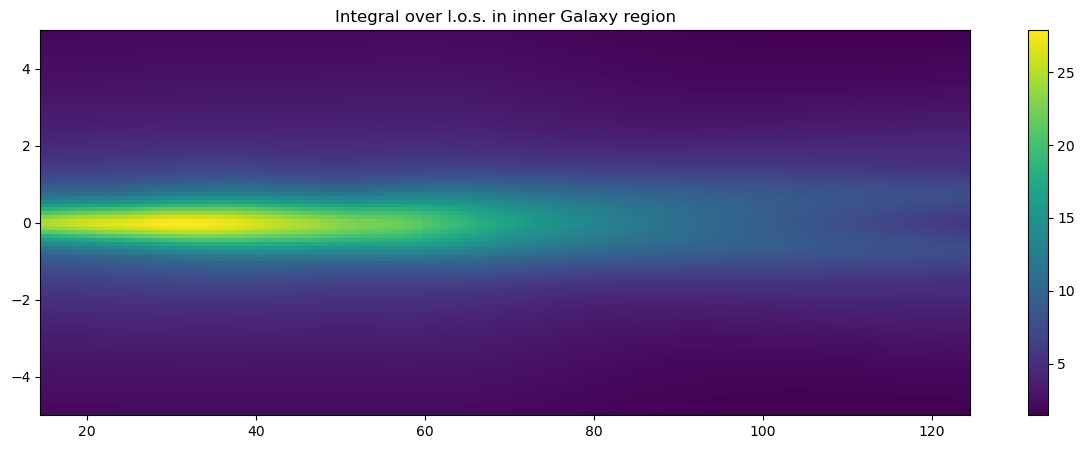

In [347]:
new_l = np.arange(15.05, 235, 1.1)
b = np.arange(-4.95, 5, 0.1)

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.pcolormesh(new_l[0:100], b, integral.T)
fig.colorbar(im)
ax.set_title('Integral over l.o.s. in inner Galaxy region')
plt.show()

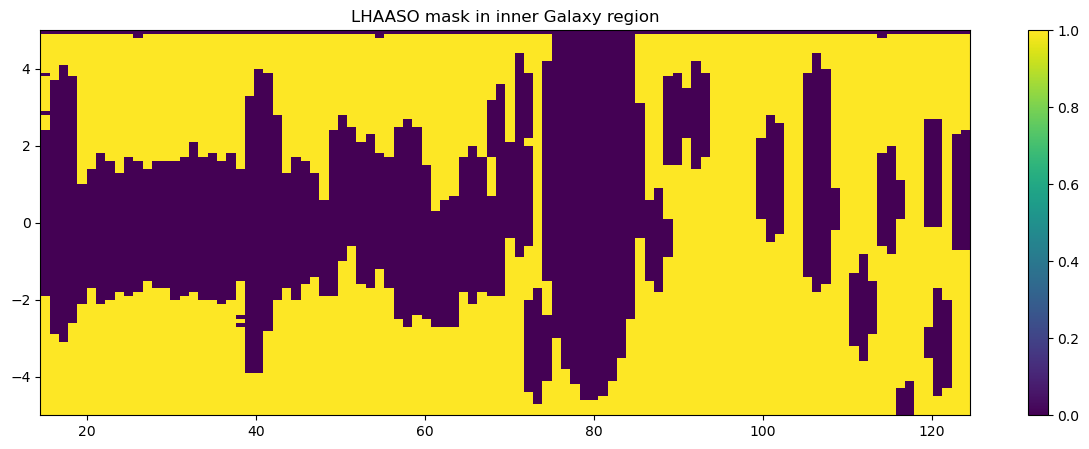

In [346]:
new_l = np.arange(15.05, 235, 1.1)
b = np.arange(-4.95, 5, 0.1)

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.pcolormesh(new_l[0:100], b, mask.T)
fig.colorbar(im)
ax.set_title('LHAASO mask in inner Galaxy region')
plt.show()

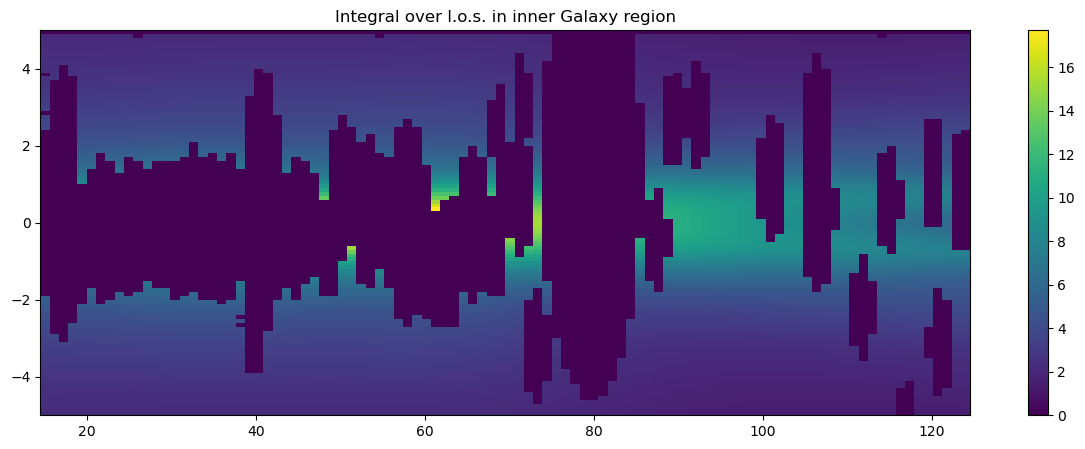

In [348]:
masked_integral = mask * integral

new_l = np.arange(15.05, 235, 1.1)
b = np.arange(-4.95, 5, 0.1)

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.pcolormesh(new_l[0:100], b, masked_integral.T)
fig.colorbar(im)
ax.set_title('Integral over l.o.s. in inner Galaxy region')
plt.show()